# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

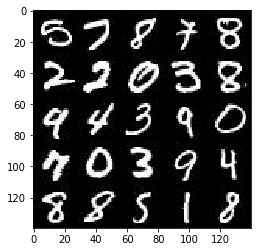

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

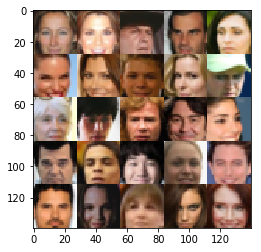

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    r_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels),
                              name='r_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='z_input')
    lr = tf.placeholder(dtype=tf.float32, name='lr')

    return r_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.01
    dropout = 0.5
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # First Layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # Second Layer
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        
        # Third Layer
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)

        # Output
        # Applying dropout 
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(dropout_layer, 1)
        output = tf.sigmoid(logits)
        
    return (output, logits)




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.01

    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        output = tf.tanh(logits)
        # 28*28*out_channel_dim
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    label_smooth = 0.1
    
    # Generator
    g_model = generator(input_z, out_channel_dim)
    # Discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
        
    # Discriminator & Generator losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)**(1 - label_smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))


    
    return (d_loss, g_loss)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimizing
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_s = 10
    show_s = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # optimize
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % show_s == 0:
                    show_generator_output(sess=sess, n_images=10, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)

                if steps % print_s == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}: ".format(epoch_i + 1, epoch_count),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2:  Discriminator Loss: 0.6871 Generator Loss: 0.7496
Epoch 1/2:  Discriminator Loss: 2.2597 Generator Loss: 16.7458
Epoch 1/2:  Discriminator Loss: 0.5041 Generator Loss: 1.1904
Epoch 1/2:  Discriminator Loss: 2.4716 Generator Loss: 0.2627
Epoch 1/2:  Discriminator Loss: 2.2475 Generator Loss: 0.1505
Epoch 1/2:  Discriminator Loss: 2.6842 Generator Loss: 0.1063
Epoch 1/2:  Discriminator Loss: 2.0353 Generator Loss: 0.1915
Epoch 1/2:  Discriminator Loss: 1.8280 Generator Loss: 0.2355
Epoch 1/2:  Discriminator Loss: 1.8210 Generator Loss: 0.2316


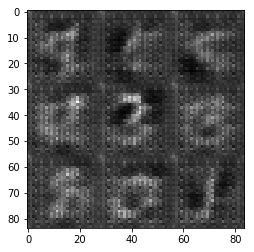

Epoch 1/2:  Discriminator Loss: 1.9535 Generator Loss: 0.2006
Epoch 1/2:  Discriminator Loss: 1.8106 Generator Loss: 0.2379
Epoch 1/2:  Discriminator Loss: 1.9019 Generator Loss: 0.2178
Epoch 1/2:  Discriminator Loss: 1.5766 Generator Loss: 0.3234
Epoch 1/2:  Discriminator Loss: 1.7662 Generator Loss: 0.2467
Epoch 1/2:  Discriminator Loss: 1.7115 Generator Loss: 0.2631
Epoch 1/2:  Discriminator Loss: 1.8257 Generator Loss: 0.2319
Epoch 1/2:  Discriminator Loss: 1.7647 Generator Loss: 0.2524
Epoch 1/2:  Discriminator Loss: 1.7758 Generator Loss: 0.2308
Epoch 1/2:  Discriminator Loss: 1.8400 Generator Loss: 0.2185


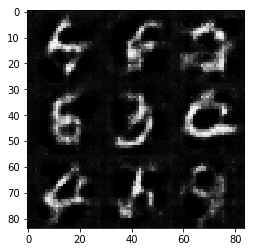

Epoch 1/2:  Discriminator Loss: 1.7704 Generator Loss: 0.2428
Epoch 1/2:  Discriminator Loss: 1.7745 Generator Loss: 0.2384
Epoch 1/2:  Discriminator Loss: 1.6286 Generator Loss: 0.3021
Epoch 1/2:  Discriminator Loss: 1.6734 Generator Loss: 0.2612
Epoch 1/2:  Discriminator Loss: 1.6244 Generator Loss: 0.2956
Epoch 1/2:  Discriminator Loss: 1.7004 Generator Loss: 0.2662
Epoch 1/2:  Discriminator Loss: 1.7134 Generator Loss: 0.2584
Epoch 1/2:  Discriminator Loss: 1.7142 Generator Loss: 0.2523
Epoch 1/2:  Discriminator Loss: 1.7864 Generator Loss: 0.2402
Epoch 1/2:  Discriminator Loss: 1.6126 Generator Loss: 0.2867


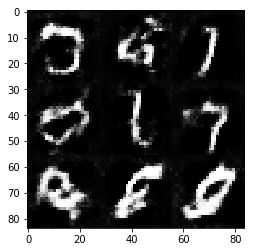

Epoch 1/2:  Discriminator Loss: 1.6015 Generator Loss: 0.3116
Epoch 1/2:  Discriminator Loss: 1.7069 Generator Loss: 0.2721
Epoch 1/2:  Discriminator Loss: 1.8368 Generator Loss: 0.2187
Epoch 1/2:  Discriminator Loss: 1.5435 Generator Loss: 0.3441
Epoch 1/2:  Discriminator Loss: 1.5754 Generator Loss: 0.3411
Epoch 1/2:  Discriminator Loss: 1.8175 Generator Loss: 0.2357
Epoch 1/2:  Discriminator Loss: 1.4137 Generator Loss: 0.4530
Epoch 1/2:  Discriminator Loss: 1.8235 Generator Loss: 0.2247
Epoch 1/2:  Discriminator Loss: 1.4198 Generator Loss: 0.4137
Epoch 1/2:  Discriminator Loss: 1.8207 Generator Loss: 0.2216


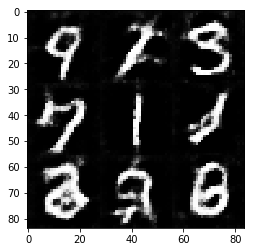

Epoch 1/2:  Discriminator Loss: 1.3644 Generator Loss: 0.4428
Epoch 1/2:  Discriminator Loss: 1.8966 Generator Loss: 0.2166
Epoch 1/2:  Discriminator Loss: 1.6255 Generator Loss: 0.2835
Epoch 1/2:  Discriminator Loss: 1.4268 Generator Loss: 0.3805
Epoch 1/2:  Discriminator Loss: 2.0674 Generator Loss: 0.1608
Epoch 1/2:  Discriminator Loss: 1.1989 Generator Loss: 0.5867
Epoch 1/2:  Discriminator Loss: 1.3733 Generator Loss: 1.8624
Epoch 1/2:  Discriminator Loss: 1.4340 Generator Loss: 1.3988
Epoch 1/2:  Discriminator Loss: 1.2049 Generator Loss: 1.2802
Epoch 1/2:  Discriminator Loss: 1.0519 Generator Loss: 0.8825


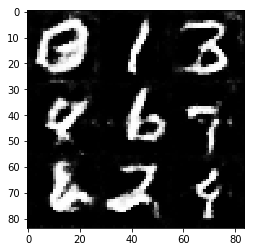

Epoch 1/2:  Discriminator Loss: 1.2816 Generator Loss: 1.1723
Epoch 1/2:  Discriminator Loss: 1.4240 Generator Loss: 1.4181
Epoch 1/2:  Discriminator Loss: 1.1611 Generator Loss: 1.0069
Epoch 1/2:  Discriminator Loss: 1.2990 Generator Loss: 1.3201
Epoch 1/2:  Discriminator Loss: 1.2271 Generator Loss: 1.5498
Epoch 1/2:  Discriminator Loss: 1.4502 Generator Loss: 1.4101
Epoch 1/2:  Discriminator Loss: 1.2095 Generator Loss: 1.3107
Epoch 1/2:  Discriminator Loss: 1.1507 Generator Loss: 1.3424
Epoch 1/2:  Discriminator Loss: 1.2026 Generator Loss: 0.6907
Epoch 1/2:  Discriminator Loss: 1.9046 Generator Loss: 0.2047


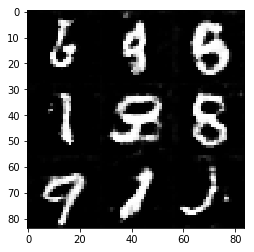

Epoch 1/2:  Discriminator Loss: 1.7855 Generator Loss: 0.2391
Epoch 1/2:  Discriminator Loss: 1.5824 Generator Loss: 0.3163
Epoch 1/2:  Discriminator Loss: 1.3814 Generator Loss: 0.4577
Epoch 1/2:  Discriminator Loss: 1.1979 Generator Loss: 0.6103
Epoch 1/2:  Discriminator Loss: 1.1833 Generator Loss: 1.2922
Epoch 1/2:  Discriminator Loss: 1.2902 Generator Loss: 1.2214
Epoch 1/2:  Discriminator Loss: 1.1749 Generator Loss: 1.2162
Epoch 1/2:  Discriminator Loss: 1.0819 Generator Loss: 1.1666
Epoch 1/2:  Discriminator Loss: 2.1457 Generator Loss: 1.7369
Epoch 1/2:  Discriminator Loss: 1.1270 Generator Loss: 1.1274


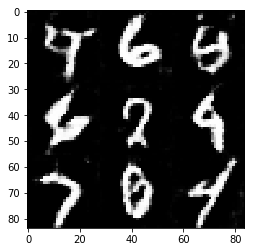

Epoch 1/2:  Discriminator Loss: 1.0518 Generator Loss: 0.8709
Epoch 1/2:  Discriminator Loss: 1.4038 Generator Loss: 1.8232
Epoch 1/2:  Discriminator Loss: 1.2328 Generator Loss: 1.3900
Epoch 1/2:  Discriminator Loss: 1.2028 Generator Loss: 0.6937
Epoch 1/2:  Discriminator Loss: 1.9804 Generator Loss: 0.2031
Epoch 1/2:  Discriminator Loss: 1.5073 Generator Loss: 0.3526
Epoch 1/2:  Discriminator Loss: 1.9470 Generator Loss: 2.3047
Epoch 1/2:  Discriminator Loss: 1.1064 Generator Loss: 1.0010
Epoch 1/2:  Discriminator Loss: 1.2538 Generator Loss: 1.4716
Epoch 1/2:  Discriminator Loss: 1.3205 Generator Loss: 1.7228


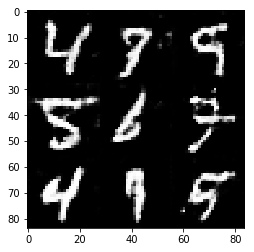

Epoch 1/2:  Discriminator Loss: 1.1554 Generator Loss: 1.0530
Epoch 1/2:  Discriminator Loss: 1.0764 Generator Loss: 1.0895
Epoch 1/2:  Discriminator Loss: 1.1583 Generator Loss: 1.6817
Epoch 1/2:  Discriminator Loss: 1.2836 Generator Loss: 1.2690
Epoch 1/2:  Discriminator Loss: 1.0185 Generator Loss: 0.8740
Epoch 1/2:  Discriminator Loss: 1.3144 Generator Loss: 1.8529
Epoch 1/2:  Discriminator Loss: 1.0056 Generator Loss: 1.1930
Epoch 1/2:  Discriminator Loss: 1.1888 Generator Loss: 0.8094
Epoch 1/2:  Discriminator Loss: 1.2459 Generator Loss: 1.2032
Epoch 1/2:  Discriminator Loss: 1.1267 Generator Loss: 1.2967


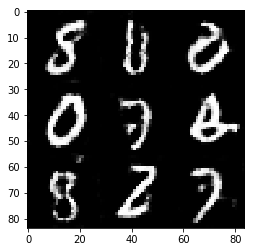

Epoch 1/2:  Discriminator Loss: 1.0957 Generator Loss: 1.0415
Epoch 1/2:  Discriminator Loss: 0.9537 Generator Loss: 1.0310
Epoch 1/2:  Discriminator Loss: 1.0514 Generator Loss: 0.9152
Epoch 1/2:  Discriminator Loss: 1.4492 Generator Loss: 1.6492
Epoch 2/2:  Discriminator Loss: 1.5321 Generator Loss: 1.8317
Epoch 2/2:  Discriminator Loss: 1.6966 Generator Loss: 0.2696
Epoch 2/2:  Discriminator Loss: 2.0735 Generator Loss: 0.1674
Epoch 2/2:  Discriminator Loss: 1.4860 Generator Loss: 0.3372
Epoch 2/2:  Discriminator Loss: 1.1903 Generator Loss: 1.5296
Epoch 2/2:  Discriminator Loss: 1.2557 Generator Loss: 1.8708


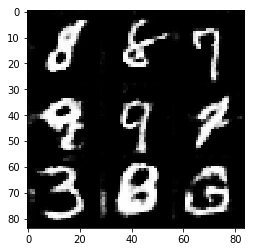

Epoch 2/2:  Discriminator Loss: 1.1517 Generator Loss: 1.3035
Epoch 2/2:  Discriminator Loss: 1.0510 Generator Loss: 1.3433
Epoch 2/2:  Discriminator Loss: 1.0125 Generator Loss: 1.0626
Epoch 2/2:  Discriminator Loss: 1.0365 Generator Loss: 1.4501
Epoch 2/2:  Discriminator Loss: 0.9862 Generator Loss: 1.5103
Epoch 2/2:  Discriminator Loss: 1.9827 Generator Loss: 2.6549
Epoch 2/2:  Discriminator Loss: 1.4032 Generator Loss: 0.4118
Epoch 2/2:  Discriminator Loss: 1.2522 Generator Loss: 0.5596
Epoch 2/2:  Discriminator Loss: 1.7088 Generator Loss: 0.2732
Epoch 2/2:  Discriminator Loss: 1.5508 Generator Loss: 0.3445


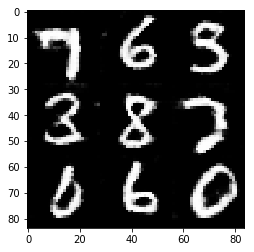

Epoch 2/2:  Discriminator Loss: 1.5885 Generator Loss: 0.3005
Epoch 2/2:  Discriminator Loss: 1.4243 Generator Loss: 0.4116
Epoch 2/2:  Discriminator Loss: 1.8472 Generator Loss: 0.2091
Epoch 2/2:  Discriminator Loss: 0.9664 Generator Loss: 1.1686
Epoch 2/2:  Discriminator Loss: 1.0648 Generator Loss: 1.4766
Epoch 2/2:  Discriminator Loss: 1.0621 Generator Loss: 1.3915
Epoch 2/2:  Discriminator Loss: 0.9675 Generator Loss: 0.9221
Epoch 2/2:  Discriminator Loss: 1.2683 Generator Loss: 0.9356
Epoch 2/2:  Discriminator Loss: 1.2062 Generator Loss: 0.9826
Epoch 2/2:  Discriminator Loss: 1.2136 Generator Loss: 1.4140


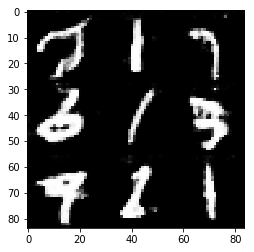

Epoch 2/2:  Discriminator Loss: 0.9643 Generator Loss: 0.9444
Epoch 2/2:  Discriminator Loss: 1.7491 Generator Loss: 0.2650
Epoch 2/2:  Discriminator Loss: 1.3445 Generator Loss: 0.3941
Epoch 2/2:  Discriminator Loss: 1.5517 Generator Loss: 0.3389
Epoch 2/2:  Discriminator Loss: 1.1203 Generator Loss: 2.0353
Epoch 2/2:  Discriminator Loss: 0.9820 Generator Loss: 1.5506
Epoch 2/2:  Discriminator Loss: 1.0806 Generator Loss: 1.7369
Epoch 2/2:  Discriminator Loss: 0.9394 Generator Loss: 1.3969
Epoch 2/2:  Discriminator Loss: 0.8331 Generator Loss: 1.1684
Epoch 2/2:  Discriminator Loss: 1.1999 Generator Loss: 1.4805


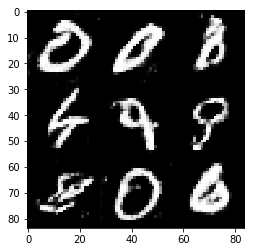

Epoch 2/2:  Discriminator Loss: 1.2408 Generator Loss: 0.5453
Epoch 2/2:  Discriminator Loss: 2.0239 Generator Loss: 0.2037
Epoch 2/2:  Discriminator Loss: 1.1858 Generator Loss: 0.5171
Epoch 2/2:  Discriminator Loss: 1.5036 Generator Loss: 0.3442
Epoch 2/2:  Discriminator Loss: 1.3707 Generator Loss: 0.4563
Epoch 2/2:  Discriminator Loss: 2.1482 Generator Loss: 0.1616
Epoch 2/2:  Discriminator Loss: 1.5024 Generator Loss: 0.3256
Epoch 2/2:  Discriminator Loss: 1.4420 Generator Loss: 0.3777
Epoch 2/2:  Discriminator Loss: 1.4969 Generator Loss: 0.3475
Epoch 2/2:  Discriminator Loss: 1.3142 Generator Loss: 0.4423


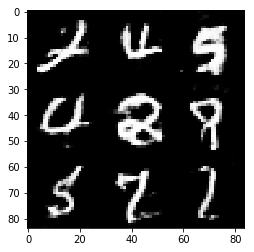

Epoch 2/2:  Discriminator Loss: 1.4662 Generator Loss: 0.3596
Epoch 2/2:  Discriminator Loss: 1.9441 Generator Loss: 0.1920
Epoch 2/2:  Discriminator Loss: 1.4400 Generator Loss: 0.3941
Epoch 2/2:  Discriminator Loss: 1.0734 Generator Loss: 0.6406
Epoch 2/2:  Discriminator Loss: 1.3572 Generator Loss: 0.4365
Epoch 2/2:  Discriminator Loss: 1.8361 Generator Loss: 0.2549
Epoch 2/2:  Discriminator Loss: 2.0215 Generator Loss: 0.1845
Epoch 2/2:  Discriminator Loss: 1.2778 Generator Loss: 0.4706
Epoch 2/2:  Discriminator Loss: 1.9029 Generator Loss: 0.2163
Epoch 2/2:  Discriminator Loss: 1.5204 Generator Loss: 0.3342


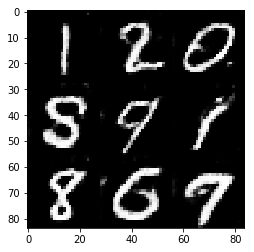

Epoch 2/2:  Discriminator Loss: 1.7637 Generator Loss: 0.3048
Epoch 2/2:  Discriminator Loss: 1.6479 Generator Loss: 0.2876
Epoch 2/2:  Discriminator Loss: 0.9030 Generator Loss: 1.1829
Epoch 2/2:  Discriminator Loss: 1.7220 Generator Loss: 2.4535
Epoch 2/2:  Discriminator Loss: 1.0363 Generator Loss: 1.8042
Epoch 2/2:  Discriminator Loss: 0.8718 Generator Loss: 1.0561
Epoch 2/2:  Discriminator Loss: 1.0197 Generator Loss: 0.7755
Epoch 2/2:  Discriminator Loss: 1.0269 Generator Loss: 1.4525
Epoch 2/2:  Discriminator Loss: 0.9738 Generator Loss: 1.3113
Epoch 2/2:  Discriminator Loss: 0.8825 Generator Loss: 1.1730


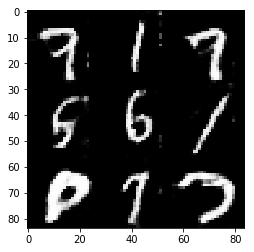

Epoch 2/2:  Discriminator Loss: 1.7897 Generator Loss: 0.2557
Epoch 2/2:  Discriminator Loss: 0.8701 Generator Loss: 0.9477
Epoch 2/2:  Discriminator Loss: 1.1042 Generator Loss: 1.8104
Epoch 2/2:  Discriminator Loss: 1.3932 Generator Loss: 0.4334
Epoch 2/2:  Discriminator Loss: 1.2976 Generator Loss: 0.4589
Epoch 2/2:  Discriminator Loss: 1.1588 Generator Loss: 0.5180
Epoch 2/2:  Discriminator Loss: 1.8138 Generator Loss: 0.2342
Epoch 2/2:  Discriminator Loss: 1.9321 Generator Loss: 0.2162
Epoch 2/2:  Discriminator Loss: 1.3632 Generator Loss: 0.4099
Epoch 2/2:  Discriminator Loss: 1.6243 Generator Loss: 0.3046


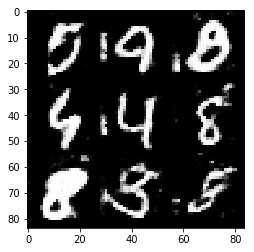

Epoch 2/2:  Discriminator Loss: 1.3449 Generator Loss: 0.3819
Epoch 2/2:  Discriminator Loss: 1.2896 Generator Loss: 0.4812
Epoch 2/2:  Discriminator Loss: 1.8062 Generator Loss: 0.2582
Epoch 2/2:  Discriminator Loss: 1.3004 Generator Loss: 0.4892
Epoch 2/2:  Discriminator Loss: 2.2365 Generator Loss: 0.1642
Epoch 2/2:  Discriminator Loss: 0.8983 Generator Loss: 0.9242
Epoch 2/2:  Discriminator Loss: 1.6578 Generator Loss: 0.2694
Epoch 2/2:  Discriminator Loss: 1.4068 Generator Loss: 0.4303
Epoch 2/2:  Discriminator Loss: 1.5834 Generator Loss: 0.3186
Epoch 2/2:  Discriminator Loss: 1.4715 Generator Loss: 0.3364


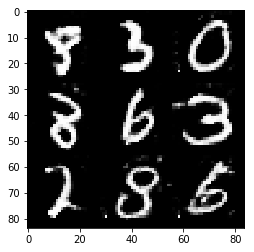

Epoch 2/2:  Discriminator Loss: 2.0217 Generator Loss: 0.2807
Epoch 2/2:  Discriminator Loss: 1.2311 Generator Loss: 0.5119
Epoch 2/2:  Discriminator Loss: 0.9923 Generator Loss: 0.7201
Epoch 2/2:  Discriminator Loss: 2.0485 Generator Loss: 0.1811
Epoch 2/2:  Discriminator Loss: 0.9292 Generator Loss: 1.9914
Epoch 2/2:  Discriminator Loss: 1.1237 Generator Loss: 1.0610
Epoch 2/2:  Discriminator Loss: 1.1145 Generator Loss: 1.2536
Epoch 2/2:  Discriminator Loss: 0.8928 Generator Loss: 0.8121


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1:  Discriminator Loss: 3.0515 Generator Loss: 0.0615
Epoch 1/1:  Discriminator Loss: 2.9446 Generator Loss: 5.1356
Epoch 1/1:  Discriminator Loss: 1.6584 Generator Loss: 0.8348
Epoch 1/1:  Discriminator Loss: 1.6743 Generator Loss: 0.9932
Epoch 1/1:  Discriminator Loss: 1.6436 Generator Loss: 0.9511
Epoch 1/1:  Discriminator Loss: 1.6440 Generator Loss: 1.1783
Epoch 1/1:  Discriminator Loss: 1.5601 Generator Loss: 0.9915
Epoch 1/1:  Discriminator Loss: 1.5902 Generator Loss: 0.7017
Epoch 1/1:  Discriminator Loss: 1.4755 Generator Loss: 0.7446


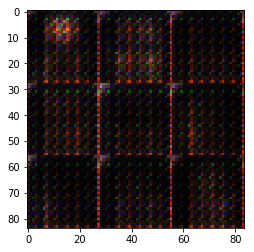

Epoch 1/1:  Discriminator Loss: 1.6720 Generator Loss: 0.8829
Epoch 1/1:  Discriminator Loss: 1.8372 Generator Loss: 0.9929
Epoch 1/1:  Discriminator Loss: 1.5098 Generator Loss: 0.8539
Epoch 1/1:  Discriminator Loss: 1.4960 Generator Loss: 0.7787
Epoch 1/1:  Discriminator Loss: 1.5673 Generator Loss: 0.9935
Epoch 1/1:  Discriminator Loss: 1.6276 Generator Loss: 1.0689
Epoch 1/1:  Discriminator Loss: 1.5358 Generator Loss: 0.9790
Epoch 1/1:  Discriminator Loss: 1.5034 Generator Loss: 0.7479
Epoch 1/1:  Discriminator Loss: 1.5178 Generator Loss: 0.5612
Epoch 1/1:  Discriminator Loss: 1.5498 Generator Loss: 0.4625


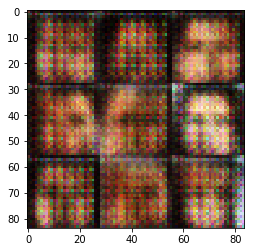

Epoch 1/1:  Discriminator Loss: 1.5457 Generator Loss: 0.4707
Epoch 1/1:  Discriminator Loss: 1.5813 Generator Loss: 0.3946
Epoch 1/1:  Discriminator Loss: 1.4855 Generator Loss: 0.4935
Epoch 1/1:  Discriminator Loss: 1.5886 Generator Loss: 0.4208
Epoch 1/1:  Discriminator Loss: 1.4687 Generator Loss: 0.5351
Epoch 1/1:  Discriminator Loss: 1.4999 Generator Loss: 0.5430
Epoch 1/1:  Discriminator Loss: 1.4552 Generator Loss: 0.7611
Epoch 1/1:  Discriminator Loss: 1.4747 Generator Loss: 0.7592
Epoch 1/1:  Discriminator Loss: 1.4612 Generator Loss: 0.9382
Epoch 1/1:  Discriminator Loss: 1.4944 Generator Loss: 0.7589


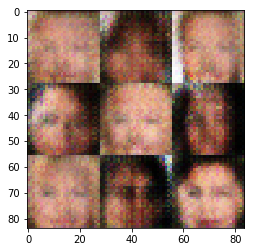

Epoch 1/1:  Discriminator Loss: 1.4926 Generator Loss: 0.8083
Epoch 1/1:  Discriminator Loss: 1.4578 Generator Loss: 0.7877
Epoch 1/1:  Discriminator Loss: 1.4214 Generator Loss: 0.7635
Epoch 1/1:  Discriminator Loss: 1.4052 Generator Loss: 0.7491
Epoch 1/1:  Discriminator Loss: 1.5080 Generator Loss: 0.4928
Epoch 1/1:  Discriminator Loss: 1.4424 Generator Loss: 0.8510
Epoch 1/1:  Discriminator Loss: 1.6882 Generator Loss: 1.2729
Epoch 1/1:  Discriminator Loss: 1.5946 Generator Loss: 0.9691
Epoch 1/1:  Discriminator Loss: 1.5159 Generator Loss: 0.9290
Epoch 1/1:  Discriminator Loss: 1.4173 Generator Loss: 0.7997


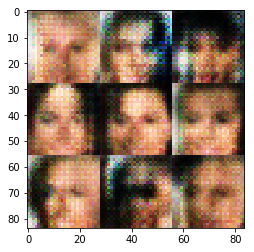

Epoch 1/1:  Discriminator Loss: 1.4867 Generator Loss: 1.0420
Epoch 1/1:  Discriminator Loss: 1.3794 Generator Loss: 1.2209
Epoch 1/1:  Discriminator Loss: 1.3106 Generator Loss: 0.4682
Epoch 1/1:  Discriminator Loss: 1.5417 Generator Loss: 0.3366
Epoch 1/1:  Discriminator Loss: 1.8081 Generator Loss: 0.2386
Epoch 1/1:  Discriminator Loss: 4.0666 Generator Loss: 2.7759
Epoch 1/1:  Discriminator Loss: 1.5369 Generator Loss: 0.6837
Epoch 1/1:  Discriminator Loss: 1.3598 Generator Loss: 0.6637
Epoch 1/1:  Discriminator Loss: 1.4315 Generator Loss: 0.7172
Epoch 1/1:  Discriminator Loss: 1.3201 Generator Loss: 0.9591


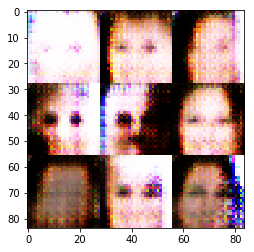

Epoch 1/1:  Discriminator Loss: 1.2678 Generator Loss: 0.5438
Epoch 1/1:  Discriminator Loss: 1.3747 Generator Loss: 0.5396
Epoch 1/1:  Discriminator Loss: 1.5099 Generator Loss: 0.3314
Epoch 1/1:  Discriminator Loss: 2.2621 Generator Loss: 0.1372
Epoch 1/1:  Discriminator Loss: 1.7251 Generator Loss: 2.0941
Epoch 1/1:  Discriminator Loss: 1.0528 Generator Loss: 0.6584
Epoch 1/1:  Discriminator Loss: 1.2886 Generator Loss: 0.5221
Epoch 1/1:  Discriminator Loss: 1.2980 Generator Loss: 0.6149
Epoch 1/1:  Discriminator Loss: 1.1088 Generator Loss: 0.8154
Epoch 1/1:  Discriminator Loss: 1.4227 Generator Loss: 1.1191


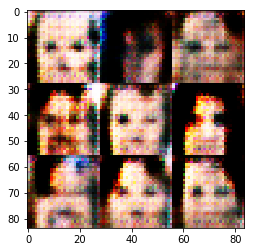

Epoch 1/1:  Discriminator Loss: 1.3704 Generator Loss: 0.4347
Epoch 1/1:  Discriminator Loss: 0.3653 Generator Loss: 1.5764
Epoch 1/1:  Discriminator Loss: 0.8571 Generator Loss: 0.8990
Epoch 1/1:  Discriminator Loss: 0.7554 Generator Loss: 1.0087
Epoch 1/1:  Discriminator Loss: 2.1177 Generator Loss: 3.0913
Epoch 1/1:  Discriminator Loss: 0.8229 Generator Loss: 1.3226
Epoch 1/1:  Discriminator Loss: 0.9703 Generator Loss: 1.6055
Epoch 1/1:  Discriminator Loss: 1.0516 Generator Loss: 0.6169
Epoch 1/1:  Discriminator Loss: 0.9112 Generator Loss: 0.7800
Epoch 1/1:  Discriminator Loss: 0.5041 Generator Loss: 1.1691


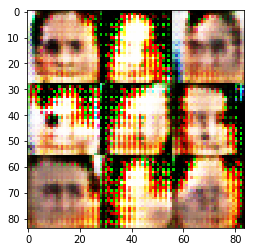

Epoch 1/1:  Discriminator Loss: 0.8432 Generator Loss: 1.0654
Epoch 1/1:  Discriminator Loss: 0.7926 Generator Loss: 1.0920
Epoch 1/1:  Discriminator Loss: 2.0357 Generator Loss: 3.0661
Epoch 1/1:  Discriminator Loss: 1.1477 Generator Loss: 0.5762
Epoch 1/1:  Discriminator Loss: 0.7833 Generator Loss: 0.8448
Epoch 1/1:  Discriminator Loss: 1.2050 Generator Loss: 0.7929
Epoch 1/1:  Discriminator Loss: 1.3530 Generator Loss: 0.4200
Epoch 1/1:  Discriminator Loss: 1.5750 Generator Loss: 1.7774
Epoch 1/1:  Discriminator Loss: 1.2890 Generator Loss: 0.6548
Epoch 1/1:  Discriminator Loss: 1.3362 Generator Loss: 0.4715


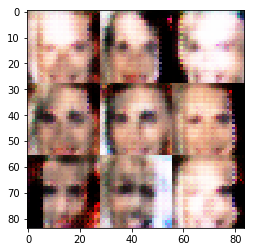

Epoch 1/1:  Discriminator Loss: 0.8074 Generator Loss: 1.6945
Epoch 1/1:  Discriminator Loss: 1.0997 Generator Loss: 0.8069
Epoch 1/1:  Discriminator Loss: 1.4002 Generator Loss: 0.3731
Epoch 1/1:  Discriminator Loss: 0.5070 Generator Loss: 2.1423
Epoch 1/1:  Discriminator Loss: 0.7951 Generator Loss: 0.8888
Epoch 1/1:  Discriminator Loss: 1.9394 Generator Loss: 0.1889
Epoch 1/1:  Discriminator Loss: 0.5852 Generator Loss: 1.2306
Epoch 1/1:  Discriminator Loss: 1.2425 Generator Loss: 0.5873
Epoch 1/1:  Discriminator Loss: 1.3971 Generator Loss: 0.8549
Epoch 1/1:  Discriminator Loss: 1.1102 Generator Loss: 0.5085


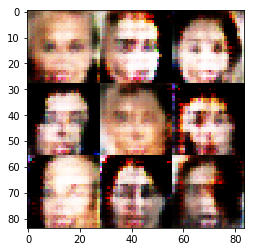

Epoch 1/1:  Discriminator Loss: 1.0683 Generator Loss: 0.9413
Epoch 1/1:  Discriminator Loss: 0.6357 Generator Loss: 1.0736
Epoch 1/1:  Discriminator Loss: 0.8410 Generator Loss: 0.7349
Epoch 1/1:  Discriminator Loss: 0.9307 Generator Loss: 0.8164
Epoch 1/1:  Discriminator Loss: 1.0518 Generator Loss: 1.3830
Epoch 1/1:  Discriminator Loss: 0.7212 Generator Loss: 0.7771
Epoch 1/1:  Discriminator Loss: 1.2471 Generator Loss: 0.4831
Epoch 1/1:  Discriminator Loss: 1.3191 Generator Loss: 1.2516
Epoch 1/1:  Discriminator Loss: 0.6509 Generator Loss: 0.8984
Epoch 1/1:  Discriminator Loss: 2.3871 Generator Loss: 0.1196


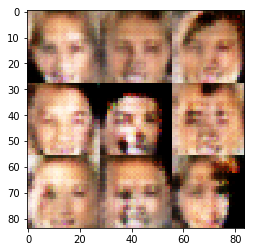

Epoch 1/1:  Discriminator Loss: 1.4229 Generator Loss: 0.7054
Epoch 1/1:  Discriminator Loss: 1.3203 Generator Loss: 0.5928
Epoch 1/1:  Discriminator Loss: 2.5226 Generator Loss: 0.2109
Epoch 1/1:  Discriminator Loss: 1.1704 Generator Loss: 3.1261
Epoch 1/1:  Discriminator Loss: 0.9868 Generator Loss: 0.8788
Epoch 1/1:  Discriminator Loss: 0.7529 Generator Loss: 0.7745
Epoch 1/1:  Discriminator Loss: 1.2522 Generator Loss: 0.7241
Epoch 1/1:  Discriminator Loss: 1.4029 Generator Loss: 0.3269
Epoch 1/1:  Discriminator Loss: 3.1996 Generator Loss: 0.0495
Epoch 1/1:  Discriminator Loss: 0.8626 Generator Loss: 1.4844


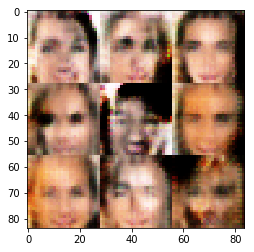

Epoch 1/1:  Discriminator Loss: 0.8639 Generator Loss: 1.2581
Epoch 1/1:  Discriminator Loss: 1.7160 Generator Loss: 0.2308
Epoch 1/1:  Discriminator Loss: 1.4495 Generator Loss: 0.4257
Epoch 1/1:  Discriminator Loss: 2.1190 Generator Loss: 0.2188
Epoch 1/1:  Discriminator Loss: 1.0962 Generator Loss: 0.8462
Epoch 1/1:  Discriminator Loss: 1.4487 Generator Loss: 0.3638
Epoch 1/1:  Discriminator Loss: 0.6804 Generator Loss: 1.1145
Epoch 1/1:  Discriminator Loss: 1.3782 Generator Loss: 1.3669
Epoch 1/1:  Discriminator Loss: 1.4238 Generator Loss: 0.7199
Epoch 1/1:  Discriminator Loss: 1.2765 Generator Loss: 0.7116


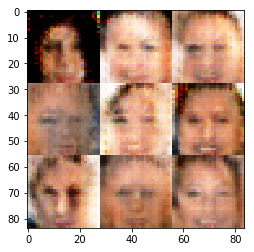

Epoch 1/1:  Discriminator Loss: 1.3559 Generator Loss: 0.5464
Epoch 1/1:  Discriminator Loss: 0.8557 Generator Loss: 0.8860
Epoch 1/1:  Discriminator Loss: 0.7231 Generator Loss: 1.3386
Epoch 1/1:  Discriminator Loss: 1.2779 Generator Loss: 1.9516
Epoch 1/1:  Discriminator Loss: 3.2471 Generator Loss: 0.0612
Epoch 1/1:  Discriminator Loss: 0.5737 Generator Loss: 1.1558
Epoch 1/1:  Discriminator Loss: 4.2207 Generator Loss: 3.0408
Epoch 1/1:  Discriminator Loss: 1.1978 Generator Loss: 0.6144
Epoch 1/1:  Discriminator Loss: 1.5270 Generator Loss: 0.6594
Epoch 1/1:  Discriminator Loss: 0.7609 Generator Loss: 1.0531


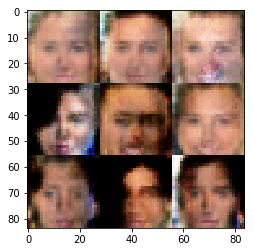

Epoch 1/1:  Discriminator Loss: 1.7069 Generator Loss: 1.6656
Epoch 1/1:  Discriminator Loss: 1.1972 Generator Loss: 0.5963
Epoch 1/1:  Discriminator Loss: 1.6872 Generator Loss: 0.8773
Epoch 1/1:  Discriminator Loss: 1.0196 Generator Loss: 0.9000
Epoch 1/1:  Discriminator Loss: 1.0839 Generator Loss: 1.1163
Epoch 1/1:  Discriminator Loss: 1.1091 Generator Loss: 0.6077
Epoch 1/1:  Discriminator Loss: 1.1329 Generator Loss: 0.7119
Epoch 1/1:  Discriminator Loss: 0.9514 Generator Loss: 1.3517
Epoch 1/1:  Discriminator Loss: 1.0988 Generator Loss: 1.2352
Epoch 1/1:  Discriminator Loss: 1.0860 Generator Loss: 0.9251


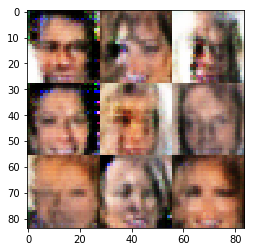

Epoch 1/1:  Discriminator Loss: 0.5026 Generator Loss: 1.0855
Epoch 1/1:  Discriminator Loss: 1.2795 Generator Loss: 1.4749
Epoch 1/1:  Discriminator Loss: 1.0680 Generator Loss: 0.7850
Epoch 1/1:  Discriminator Loss: 0.9992 Generator Loss: 0.7867
Epoch 1/1:  Discriminator Loss: 0.7289 Generator Loss: 1.7786
Epoch 1/1:  Discriminator Loss: 1.3686 Generator Loss: 0.5285
Epoch 1/1:  Discriminator Loss: 1.2229 Generator Loss: 0.7588
Epoch 1/1:  Discriminator Loss: 1.8016 Generator Loss: 0.2459
Epoch 1/1:  Discriminator Loss: 0.8934 Generator Loss: 1.3596
Epoch 1/1:  Discriminator Loss: 1.1332 Generator Loss: 0.4248


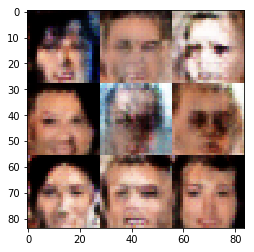

Epoch 1/1:  Discriminator Loss: 1.3100 Generator Loss: 1.2403
Epoch 1/1:  Discriminator Loss: 1.7374 Generator Loss: 1.8561
Epoch 1/1:  Discriminator Loss: 1.4088 Generator Loss: 0.5491
Epoch 1/1:  Discriminator Loss: 0.9389 Generator Loss: 0.8298
Epoch 1/1:  Discriminator Loss: 1.0478 Generator Loss: 0.7148
Epoch 1/1:  Discriminator Loss: 1.1012 Generator Loss: 0.6585
Epoch 1/1:  Discriminator Loss: 1.0824 Generator Loss: 0.9136
Epoch 1/1:  Discriminator Loss: 1.1479 Generator Loss: 0.8694
Epoch 1/1:  Discriminator Loss: 1.2929 Generator Loss: 0.4720
Epoch 1/1:  Discriminator Loss: 1.1860 Generator Loss: 0.6122


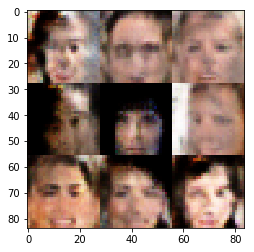

Epoch 1/1:  Discriminator Loss: 1.0602 Generator Loss: 0.5047
Epoch 1/1:  Discriminator Loss: 1.3697 Generator Loss: 0.8136
Epoch 1/1:  Discriminator Loss: 0.5137 Generator Loss: 1.7856
Epoch 1/1:  Discriminator Loss: 0.9929 Generator Loss: 0.9651
Epoch 1/1:  Discriminator Loss: 1.4845 Generator Loss: 0.4700
Epoch 1/1:  Discriminator Loss: 1.0429 Generator Loss: 1.2277
Epoch 1/1:  Discriminator Loss: 1.0997 Generator Loss: 1.0377
Epoch 1/1:  Discriminator Loss: 1.0987 Generator Loss: 1.0715
Epoch 1/1:  Discriminator Loss: 0.9662 Generator Loss: 0.7261
Epoch 1/1:  Discriminator Loss: 1.4718 Generator Loss: 0.6426


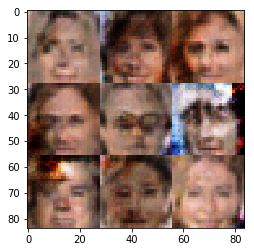

Epoch 1/1:  Discriminator Loss: 1.4362 Generator Loss: 0.5316
Epoch 1/1:  Discriminator Loss: 1.3451 Generator Loss: 0.3613
Epoch 1/1:  Discriminator Loss: 0.7833 Generator Loss: 0.8435
Epoch 1/1:  Discriminator Loss: 0.8864 Generator Loss: 0.8135
Epoch 1/1:  Discriminator Loss: 0.7706 Generator Loss: 0.7936
Epoch 1/1:  Discriminator Loss: 1.8092 Generator Loss: 0.2443
Epoch 1/1:  Discriminator Loss: 0.6521 Generator Loss: 1.2014
Epoch 1/1:  Discriminator Loss: 1.0503 Generator Loss: 0.5258
Epoch 1/1:  Discriminator Loss: 1.3160 Generator Loss: 0.8476
Epoch 1/1:  Discriminator Loss: 1.1558 Generator Loss: 0.7470


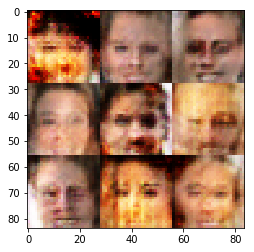

Epoch 1/1:  Discriminator Loss: 1.1825 Generator Loss: 0.8050
Epoch 1/1:  Discriminator Loss: 1.0937 Generator Loss: 1.2748
Epoch 1/1:  Discriminator Loss: 0.9742 Generator Loss: 0.6911
Epoch 1/1:  Discriminator Loss: 1.2114 Generator Loss: 0.6695
Epoch 1/1:  Discriminator Loss: 1.4635 Generator Loss: 0.6196
Epoch 1/1:  Discriminator Loss: 1.0628 Generator Loss: 0.8337
Epoch 1/1:  Discriminator Loss: 1.3841 Generator Loss: 0.9912
Epoch 1/1:  Discriminator Loss: 1.0547 Generator Loss: 0.9545
Epoch 1/1:  Discriminator Loss: 1.1253 Generator Loss: 0.6900
Epoch 1/1:  Discriminator Loss: 0.9778 Generator Loss: 0.9400


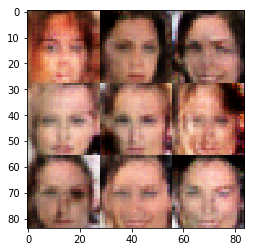

Epoch 1/1:  Discriminator Loss: 0.9576 Generator Loss: 1.0027
Epoch 1/1:  Discriminator Loss: 0.9924 Generator Loss: 0.7572
Epoch 1/1:  Discriminator Loss: 1.0903 Generator Loss: 1.0844
Epoch 1/1:  Discriminator Loss: 1.2466 Generator Loss: 0.4967
Epoch 1/1:  Discriminator Loss: 1.1276 Generator Loss: 0.6449
Epoch 1/1:  Discriminator Loss: 1.0637 Generator Loss: 0.8869
Epoch 1/1:  Discriminator Loss: 0.9102 Generator Loss: 0.9433
Epoch 1/1:  Discriminator Loss: 1.1406 Generator Loss: 0.6706
Epoch 1/1:  Discriminator Loss: 0.9711 Generator Loss: 0.8094
Epoch 1/1:  Discriminator Loss: 0.9630 Generator Loss: 0.6664


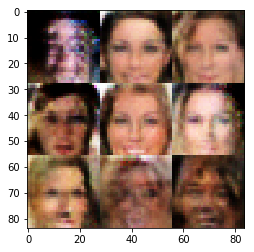

Epoch 1/1:  Discriminator Loss: 0.8358 Generator Loss: 0.7062
Epoch 1/1:  Discriminator Loss: 0.6242 Generator Loss: 0.9577
Epoch 1/1:  Discriminator Loss: 1.8901 Generator Loss: 0.3673
Epoch 1/1:  Discriminator Loss: 1.6291 Generator Loss: 0.4891
Epoch 1/1:  Discriminator Loss: 1.1077 Generator Loss: 0.8490
Epoch 1/1:  Discriminator Loss: 1.3241 Generator Loss: 0.8384
Epoch 1/1:  Discriminator Loss: 1.1479 Generator Loss: 0.7885
Epoch 1/1:  Discriminator Loss: 2.1975 Generator Loss: 0.2154
Epoch 1/1:  Discriminator Loss: 1.2832 Generator Loss: 0.9668
Epoch 1/1:  Discriminator Loss: 1.0331 Generator Loss: 0.8518


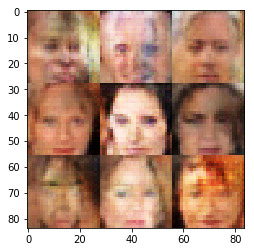

Epoch 1/1:  Discriminator Loss: 1.0082 Generator Loss: 1.2087
Epoch 1/1:  Discriminator Loss: 1.3252 Generator Loss: 0.3888
Epoch 1/1:  Discriminator Loss: 1.0314 Generator Loss: 0.7401
Epoch 1/1:  Discriminator Loss: 1.1035 Generator Loss: 0.5598
Epoch 1/1:  Discriminator Loss: 1.1952 Generator Loss: 1.3169
Epoch 1/1:  Discriminator Loss: 2.7292 Generator Loss: 2.1375
Epoch 1/1:  Discriminator Loss: 1.1881 Generator Loss: 0.6528
Epoch 1/1:  Discriminator Loss: 1.2207 Generator Loss: 0.8753
Epoch 1/1:  Discriminator Loss: 1.2796 Generator Loss: 0.5747
Epoch 1/1:  Discriminator Loss: 1.2233 Generator Loss: 0.6751


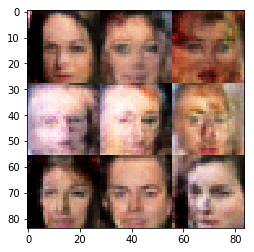

Epoch 1/1:  Discriminator Loss: 0.7619 Generator Loss: 0.7519
Epoch 1/1:  Discriminator Loss: 2.2126 Generator Loss: 1.4882
Epoch 1/1:  Discriminator Loss: 1.2808 Generator Loss: 0.7523
Epoch 1/1:  Discriminator Loss: 1.3315 Generator Loss: 0.9520
Epoch 1/1:  Discriminator Loss: 1.0020 Generator Loss: 1.0050
Epoch 1/1:  Discriminator Loss: 0.9265 Generator Loss: 0.7163
Epoch 1/1:  Discriminator Loss: 1.1208 Generator Loss: 0.6573
Epoch 1/1:  Discriminator Loss: 0.8922 Generator Loss: 1.5990
Epoch 1/1:  Discriminator Loss: 1.4249 Generator Loss: 0.3950
Epoch 1/1:  Discriminator Loss: 1.4557 Generator Loss: 0.4622


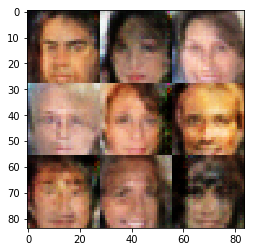

Epoch 1/1:  Discriminator Loss: 1.6077 Generator Loss: 1.4397
Epoch 1/1:  Discriminator Loss: 1.8856 Generator Loss: 0.2708
Epoch 1/1:  Discriminator Loss: 1.1598 Generator Loss: 0.6256
Epoch 1/1:  Discriminator Loss: 1.0931 Generator Loss: 0.6220
Epoch 1/1:  Discriminator Loss: 1.0750 Generator Loss: 1.1243
Epoch 1/1:  Discriminator Loss: 0.8119 Generator Loss: 0.8578
Epoch 1/1:  Discriminator Loss: 1.9918 Generator Loss: 0.2483
Epoch 1/1:  Discriminator Loss: 0.7064 Generator Loss: 0.8973
Epoch 1/1:  Discriminator Loss: 1.2463 Generator Loss: 0.4635
Epoch 1/1:  Discriminator Loss: 1.0630 Generator Loss: 1.0135


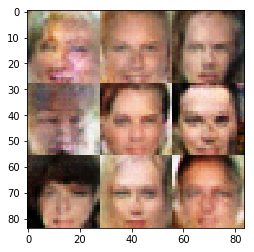

Epoch 1/1:  Discriminator Loss: 1.4302 Generator Loss: 0.5626
Epoch 1/1:  Discriminator Loss: 1.1608 Generator Loss: 0.6013
Epoch 1/1:  Discriminator Loss: 1.2856 Generator Loss: 0.4334
Epoch 1/1:  Discriminator Loss: 0.8133 Generator Loss: 0.7353
Epoch 1/1:  Discriminator Loss: 3.5977 Generator Loss: 0.0411
Epoch 1/1:  Discriminator Loss: 0.8961 Generator Loss: 0.7900
Epoch 1/1:  Discriminator Loss: 1.2498 Generator Loss: 0.8778
Epoch 1/1:  Discriminator Loss: 1.0880 Generator Loss: 0.5563
Epoch 1/1:  Discriminator Loss: 1.1873 Generator Loss: 0.8309
Epoch 1/1:  Discriminator Loss: 1.4752 Generator Loss: 1.8675


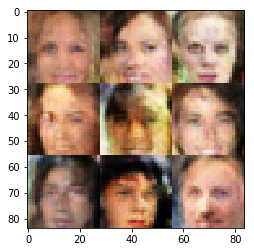

Epoch 1/1:  Discriminator Loss: 1.4757 Generator Loss: 0.4900
Epoch 1/1:  Discriminator Loss: 1.3336 Generator Loss: 0.5123
Epoch 1/1:  Discriminator Loss: 1.5852 Generator Loss: 0.4151
Epoch 1/1:  Discriminator Loss: 0.9731 Generator Loss: 0.6794
Epoch 1/1:  Discriminator Loss: 1.2083 Generator Loss: 0.7354
Epoch 1/1:  Discriminator Loss: 1.0249 Generator Loss: 0.6856
Epoch 1/1:  Discriminator Loss: 1.1219 Generator Loss: 0.8356
Epoch 1/1:  Discriminator Loss: 0.8595 Generator Loss: 0.9292
Epoch 1/1:  Discriminator Loss: 1.3989 Generator Loss: 0.5073
Epoch 1/1:  Discriminator Loss: 1.4796 Generator Loss: 0.6118


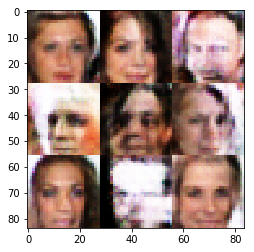

Epoch 1/1:  Discriminator Loss: 1.4579 Generator Loss: 1.4107
Epoch 1/1:  Discriminator Loss: 1.1745 Generator Loss: 0.9364
Epoch 1/1:  Discriminator Loss: 1.2704 Generator Loss: 0.7167
Epoch 1/1:  Discriminator Loss: 0.8393 Generator Loss: 0.8451
Epoch 1/1:  Discriminator Loss: 1.2422 Generator Loss: 0.6084
Epoch 1/1:  Discriminator Loss: 1.2966 Generator Loss: 0.6623
Epoch 1/1:  Discriminator Loss: 1.2611 Generator Loss: 0.7848
Epoch 1/1:  Discriminator Loss: 1.2651 Generator Loss: 0.5469
Epoch 1/1:  Discriminator Loss: 1.1518 Generator Loss: 0.4499
Epoch 1/1:  Discriminator Loss: 1.0833 Generator Loss: 0.8395


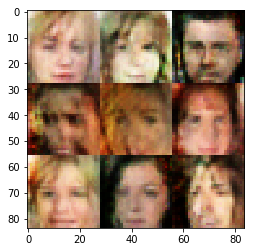

Epoch 1/1:  Discriminator Loss: 1.2773 Generator Loss: 0.5864
Epoch 1/1:  Discriminator Loss: 0.8122 Generator Loss: 0.6656
Epoch 1/1:  Discriminator Loss: 1.2116 Generator Loss: 0.5649
Epoch 1/1:  Discriminator Loss: 1.2997 Generator Loss: 0.8404
Epoch 1/1:  Discriminator Loss: 1.1388 Generator Loss: 0.9866
Epoch 1/1:  Discriminator Loss: 1.6051 Generator Loss: 0.3813
Epoch 1/1:  Discriminator Loss: 1.3461 Generator Loss: 0.6963
Epoch 1/1:  Discriminator Loss: 1.4336 Generator Loss: 0.4187
Epoch 1/1:  Discriminator Loss: 1.1868 Generator Loss: 0.5427
Epoch 1/1:  Discriminator Loss: 1.3963 Generator Loss: 0.4610


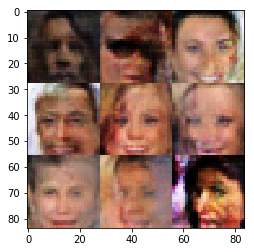

Epoch 1/1:  Discriminator Loss: 1.2731 Generator Loss: 0.6094
Epoch 1/1:  Discriminator Loss: 1.1327 Generator Loss: 0.6355
Epoch 1/1:  Discriminator Loss: 2.3706 Generator Loss: 0.1221
Epoch 1/1:  Discriminator Loss: 1.3990 Generator Loss: 0.4784
Epoch 1/1:  Discriminator Loss: 1.0353 Generator Loss: 0.6797
Epoch 1/1:  Discriminator Loss: 1.2261 Generator Loss: 0.5139
Epoch 1/1:  Discriminator Loss: 3.2490 Generator Loss: 0.0760
Epoch 1/1:  Discriminator Loss: 1.2509 Generator Loss: 0.6466
Epoch 1/1:  Discriminator Loss: 0.9657 Generator Loss: 0.7691
Epoch 1/1:  Discriminator Loss: 1.4804 Generator Loss: 0.4929


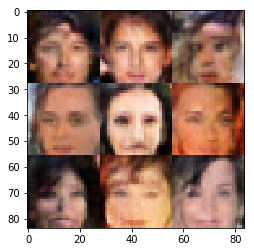

Epoch 1/1:  Discriminator Loss: 1.2037 Generator Loss: 0.6781
Epoch 1/1:  Discriminator Loss: 1.3067 Generator Loss: 0.5927
Epoch 1/1:  Discriminator Loss: 1.2179 Generator Loss: 0.7619
Epoch 1/1:  Discriminator Loss: 1.2545 Generator Loss: 0.5321
Epoch 1/1:  Discriminator Loss: 1.0824 Generator Loss: 0.7046
Epoch 1/1:  Discriminator Loss: 1.5427 Generator Loss: 0.3539
Epoch 1/1:  Discriminator Loss: 1.2108 Generator Loss: 0.6606
Epoch 1/1:  Discriminator Loss: 1.0995 Generator Loss: 0.9542
Epoch 1/1:  Discriminator Loss: 1.7466 Generator Loss: 0.2521
Epoch 1/1:  Discriminator Loss: 1.4354 Generator Loss: 0.5941


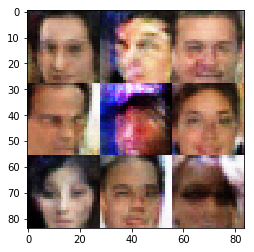

Epoch 1/1:  Discriminator Loss: 1.3760 Generator Loss: 0.4139
Epoch 1/1:  Discriminator Loss: 1.3025 Generator Loss: 0.9620
Epoch 1/1:  Discriminator Loss: 1.1994 Generator Loss: 0.5149
Epoch 1/1:  Discriminator Loss: 1.2150 Generator Loss: 0.9385
Epoch 1/1:  Discriminator Loss: 1.4254 Generator Loss: 0.9959
Epoch 1/1:  Discriminator Loss: 1.0608 Generator Loss: 0.6277
Epoch 1/1:  Discriminator Loss: 1.2123 Generator Loss: 0.8895
Epoch 1/1:  Discriminator Loss: 1.3111 Generator Loss: 0.6038
Epoch 1/1:  Discriminator Loss: 1.3076 Generator Loss: 0.8750
Epoch 1/1:  Discriminator Loss: 1.2823 Generator Loss: 0.7931


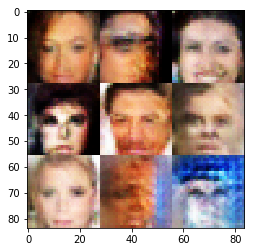

Epoch 1/1:  Discriminator Loss: 0.9844 Generator Loss: 0.6550
Epoch 1/1:  Discriminator Loss: 0.9209 Generator Loss: 0.9850
Epoch 1/1:  Discriminator Loss: 1.1078 Generator Loss: 0.8014
Epoch 1/1:  Discriminator Loss: 1.3741 Generator Loss: 1.2385
Epoch 1/1:  Discriminator Loss: 1.3587 Generator Loss: 0.6630
Epoch 1/1:  Discriminator Loss: 1.1236 Generator Loss: 0.9583
Epoch 1/1:  Discriminator Loss: 1.3152 Generator Loss: 0.5162


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.